## GAN Assignment

In [2]:
## imports
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

## 1. Load & Preprocess MNIST Data

In [3]:
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize to [-1, 1]
x_train = (x_train.astype("float32") - 127.5) / 127.5

# Reshape to (28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)

BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)

## 2. Generator

In [4]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 256)),

        layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same',
                               use_bias=False, activation='tanh')
    ])
    return model

generator = build_generator()

c:\Users\arjun\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 3. Discriminator

In [5]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5,5), strides=(2,2), padding='same',
                      input_shape=[28,28,1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

discriminator = build_discriminator()

c:\Users\arjun\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 4. Loss and Optimizers

In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

## 5. Training

In [7]:
noise_dim = 100

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss

## 6. Image generation

In [8]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}")
    plt.show()

## 7. Training with 20 Epochs

Epoch 1, Generator Loss: 0.6674, Discriminator Loss: 1.4076
Epoch 2, Generator Loss: 0.5595, Discriminator Loss: 1.5275
Epoch 3, Generator Loss: 0.7578, Discriminator Loss: 1.2719
Epoch 4, Generator Loss: 0.7666, Discriminator Loss: 1.3291


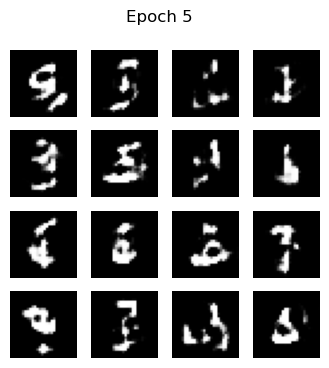

Epoch 5, Generator Loss: 1.0852, Discriminator Loss: 1.1255
Epoch 6, Generator Loss: 0.8504, Discriminator Loss: 1.4191
Epoch 7, Generator Loss: 0.9532, Discriminator Loss: 1.1689
Epoch 8, Generator Loss: 0.7250, Discriminator Loss: 1.2512
Epoch 9, Generator Loss: 0.8699, Discriminator Loss: 1.1779


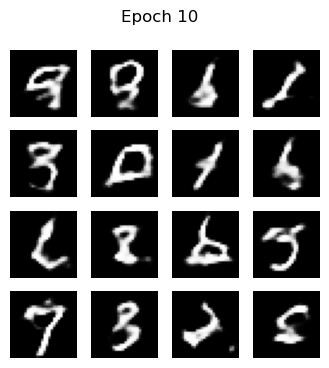

Epoch 10, Generator Loss: 0.7402, Discriminator Loss: 1.4094
Epoch 11, Generator Loss: 0.7997, Discriminator Loss: 1.3249
Epoch 12, Generator Loss: 0.8024, Discriminator Loss: 1.5118
Epoch 13, Generator Loss: 0.9110, Discriminator Loss: 1.2563
Epoch 14, Generator Loss: 0.6861, Discriminator Loss: 1.3412


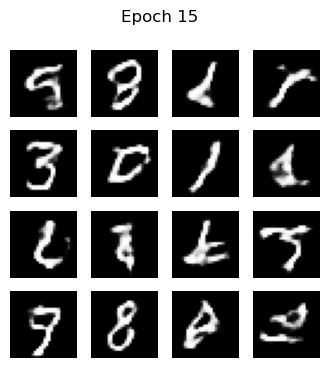

Epoch 15, Generator Loss: 0.7270, Discriminator Loss: 1.3382
Epoch 16, Generator Loss: 0.7458, Discriminator Loss: 1.3255
Epoch 17, Generator Loss: 0.8003, Discriminator Loss: 1.2182
Epoch 18, Generator Loss: 0.8061, Discriminator Loss: 1.2598
Epoch 19, Generator Loss: 0.6751, Discriminator Loss: 1.3343


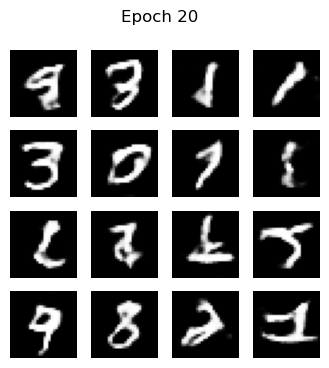

Epoch 20, Generator Loss: 0.8486, Discriminator Loss: 1.2049


In [9]:
EPOCHS = 20
seed = tf.random.normal([16, noise_dim])

gen_losses = []
disc_losses = []

for epoch in range(EPOCHS):
    for image_batch in train_dataset:
        g_loss, d_loss = train_step(image_batch)

    gen_losses.append(g_loss)
    disc_losses.append(d_loss)

    if (epoch + 1) % 5 == 0:
        generate_and_save_images(generator, epoch + 1, seed)

    print(f"Epoch {epoch+1}, Generator Loss: {g_loss:.4f}, Discriminator Loss: {d_loss:.4f}")

## 8. Plot loss Curves

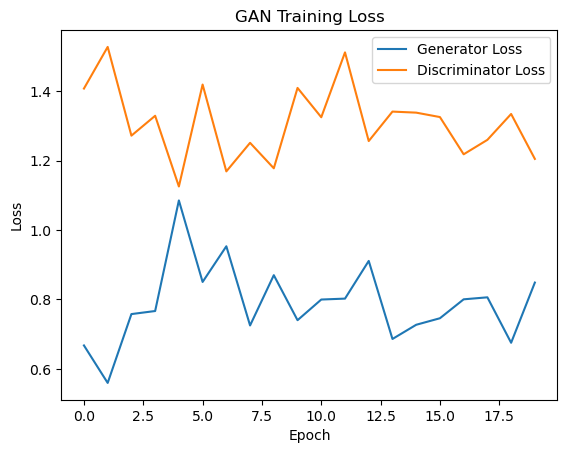

In [10]:
plt.plot(gen_losses, label="Generator Loss")
plt.plot(disc_losses, label="Discriminator Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Training Loss")
plt.show()